### Movie Generate Prediction

Exploratory Data Analysis and initial model training

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
import numpy as np
import pandas as pd
import dill
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from tqdm import tqdm
from unidecode import unidecode
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  (accuracy_score, f1_score, precision_score,
    recall_score, confusion_matrix, multilabel_confusion_matrix,
    classification_report, make_scorer, fbeta_score
)
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
tqdm.pandas()

from config.paths import MODEL_PATH, GENRES_PATH

In [13]:
# Download titles datasets from IMDB
# One of the datasets contains the genres and the other contains language information,
# which we'll use to filter
# down to English movies

# !curl https://datasets.imdbws.com/title.basics.tsv.gz --output data/title.basics.tsv.gz
# !curl https://datasets.imdbws.com/title.akas.tsv.gz --output data/title.akas.tsv.gz

In [15]:
# Unzip .gz files
# !gzip -d data/title.basics.tsv.gz
# !gzip -d data/title.akas.tsv.gz

In [16]:
# Read tab-separated files
titles1 = pd.read_csv('data/title.basics.tsv', sep='\t')
titles2 = pd.read_csv('data/title.akas.tsv', sep='\t')

/var/folders/y4/vx3h67ld48ld9y909666j4wr0000gp/T/ipykernel_41958/1011171270.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles1 = pd.read_csv('data/title.basics.tsv', sep='\t')
/var/folders/y4/vx3h67ld48ld9y909666j4wr0000gp/T/ipykernel_41958/1011171270.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  titles2 = pd.read_csv('data/title.akas.tsv', sep='\t')


In [17]:
titles1.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [19]:
titles2.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0


In [20]:
# Based on the documentation at https://www.imdb.com/interfaces/ I thought
# title would be in english if language='en', but that's not the case

# Will merge first and investigate/filter once joined
titles2[titles2['language'] == 'en'].head(5)

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
39,tt0000005,4,Blacksmith Scene,CA,en,imdbDisplay,\N,0
97,tt0000010,6,La sortie de l'usine Lumière à Lyon,CA,en,imdbDisplay,\N,0
117,tt0000012,22,The Arrival of a Train,XWW,en,imdbDisplay,\N,0
119,tt0000012,24,L'arrivée d'un train à La Ciotat,CA,en,imdbDisplay,\N,0
122,tt0000012,27,The Arrival of a Train,XEU,en,imdbDisplay,\N,0


In [21]:
# Join titles1 and titles2 to get the language info from titles2 and genre info from titles1
raw = pd.merge(titles1, titles2, how='inner', left_on='tconst', right_on='titleId')
del titles1, titles2

In [22]:
# Looks like 'primaryTitle' is the english title in this case
raw[raw['titleId'] == 'tt0000010'].head(10)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
76,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,10,Вихід робітників із фабрики,UA,\N,imdbDisplay,\N,0
77,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,11,La salida de la fábrica Lumière en Lyon,ES,\N,imdbDisplay,\N,0
78,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,12,Työntekijät poistuvat Lumière-tehtaalta,FI,\N,\N,informal title,0
79,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,13,A munkaidő vége,HU,\N,imdbDisplay,\N,0
80,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,14,Wyjście robotników z fabryki,PL,\N,imdbDisplay,\N,0
81,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,15,Lumière-fabrikens arbetare,FI,sv,\N,informal title,0
82,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,16,Exiting the Factory,US,\N,imdbDisplay,\N,0
83,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,17,La sortie de l'usine Lumière,FR,\N,alternative,\N,0
84,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,18,La sortie de l'usine Lumière à Lyon,\N,\N,original,\N,1
85,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,19,La sortie des usines Lumière,FR,\N,alternative,\N,0


In [23]:
# Further investigation of language/region combinations
raw[raw['language'] == 'en'].head(10) \
    [['primaryTitle', 'originalTitle', 'title', 'language', 'region']]

,primaryTitle,originalTitle,title,language,region
39,Blacksmith Scene,Blacksmith Scene,Blacksmith Scene,en,CA
97,Leaving the Factory,La sortie de l'usine Lumière à Lyon,La sortie de l'usine Lumière à Lyon,en,CA
117,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XWW
119,The Arrival of a Train,L'arrivée d'un train à La Ciotat,L'arrivée d'un train à La Ciotat,en,CA
122,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XEU
131,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train at La Ciotat,en,XWW
133,The Photographical Congress Arrives in Lyon,Le débarquement du congrès de photographie à Lyon,The Photographical Congress Arrives in Lyon,en,XWW
179,Boat Leaving the Port,Barque sortant du port,Boat Leaving the Port,en,XWW
212,The Sea,Baignade en mer,A Dip in the Sea,en,XWW
221,The Sea,Baignade en mer,The Sea,en,XWW


In [24]:
# Look at the top 20 regions
raw['region'].value_counts().iloc[:20]

DE     4124462
JP     4122413
FR     4122187
IN     4060235
ES     4044715
IT     4024110
PT     3957765
\N     1876222
US     1402381
GB      433824
CA      214998
XWW     168622
AU      127904
BR      115143
RU       92845
MX       92724
GR       91231
PL       86864
FI       86199
SE       74843
Name: region, dtype: int64

In [25]:
# Look at all entries for one titleId with multiple languages
# Notice that the 'title' column is not always in english, even when
# the language is 'en' 
# i.e. title = 'L'arrivée d'un train à La Ciotat' when language = 'en')
raw[raw['titleId'] == 'tt0000012'] \
        .sort_values(by=['language'], ascending=False) \
        .head(10) \
        [['titleId','primaryTitle', 'originalTitle','title', 'language','region']]

,titleId,primaryTitle,originalTitle,title,language,region
109,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Bir trenin La Ciotat garına varışı,tr,TR
130,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Tåget anländer till stationen,sv,FI
120,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,ラ・シオタ駅への列車の到着,ja,JP
131,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train at La Ciotat,en,XWW
119,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,L'arrivée d'un train à La Ciotat,en,CA
122,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XEU
117,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XWW
129,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,A Chegada de um Trem à Estação,\N,BR
128,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Долазак воза на станицу,\N,RS
127,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Príchod vlaku do stanice La Ciotat,\N,SK


In [26]:
en_regions = ['US', 'GB', 'AUS']

In [27]:
# What about for the regions with a large proportion of english speakers? (US, GB, AUS?)
# Unfortunately most movies in these regions aren't listed as english
raw.query('region in @en_regions')\
    ['language'].value_counts()

\N     1831193
en        4165
es         647
cy          83
yi          64
gd          47
fr           2
hi           1
haw          1
myv          1
cr           1
Name: language, dtype: int64

In [28]:
# Are titles in the XWW region mostly labeled as english? - yes they are!
raw.query('region == "XWW"')['language'].value_counts()

en     166086
\N       1376
es        982
la        109
cmn        48
fr          8
de          3
it          2
ko          2
vi          1
sr          1
zh          1
pt          1
hu          1
ca          1
Name: language, dtype: int64

In [29]:
# Look at titles for the 'XWW' region, which is world-wide release according
# to this forum post:
# https://community-imdb.sprinklr.com/conversations/data-issues-policy-discussions/language-in-titleakastsv/5f4a79f28815453dba91a443

# Looks like this is pretty effective at finding english titles!
raw.query('region == "XWW" and language == "en"') \
    .sample(10) \
    [['titleId','primaryTitle', 'originalTitle','title', 'language','region', 'genres']]

,titleId,primaryTitle,originalTitle,title,language,region,genres
1569115,tt0296373,The Spring,El manantial,The Spring,en,XWW,"Drama,Romance"
26465562,tt4756838,The Prostitute,Aru jokô ki,The Prostitute,en,XWW,Drama
664907,tt0082626,A Monstrous Corpse,Goeshi,A Monstrous Corpse,en,XWW,"Fantasy,Horror"
1716561,tt0348233,Tou fa luan le,Tou fa luan le,Dirt,en,XWW,Drama
21670588,tt2243181,Bokuro nikki: Jôyoku no kisetsu,Bokuro nikki: Jôyoku no kisetsu,Exposure Diary: Season of Lust,en,XWW,\N
24672440,tt3461524,Heritages,Mirath,Heritages,en,XWW,"Biography,Drama"
9992853,tt13016388,The Three-Body Problem,The Three-Body Problem,3 Body Problem,en,XWW,"Adventure,Drama,Fantasy"
1266407,tt0194460,Tout pour rien,Tout pour rien,All for Nothing,en,XWW,Comedy
29734272,tt7112900,Hiko shonen,Hiko shonen,Delinquent Young Boys,en,XWW,"Action,Crime,Drama"
9543962,tt12816922,What's Up Connection,Tenamonya Connection,What's Up Connection,en,XWW,"Comedy,Drama"


In [30]:
# Final dataset combinations that appear to be mostly english titles
df_filters = [
    {
        'region': ['XWW'],
        'language': ['en']
    },
    {
        'region' : ['US', 'AUS', 'GB'],
        'language': ['en', r'\N']
    }
]

In [31]:
temp = []
for filter in df_filters:
    temp.append(
        raw.query('region in @filter["region"] and language in @filter["language"]')
    )
df = pd.concat(temp).copy()
del temp
del raw

In [32]:
# Looks good after filtering. Using 'title' column as source of truth
df.sample(20)[['titleId', 'title', 'language','region', 'genres']]

,titleId,title,language,region,genres
28282652,tt6077150,Brides of Wankenstein,\N,US,Adult
2802156,tt0793876,Great Expectations,\N,US,"Comedy,Family,Music"
30122328,tt7355616,Bridgefield,\N,US,Drama
454279,tt0061176,"What Did You Do in the War, Daddy?",\N,GB,"Comedy,War"
14933,tt0004979,Blind Man's Bluff,en,XWW,Comedy
22890597,tt24230352,Bloom,\N,US,"Short,Thriller"
28122024,tt5950206,"Ethel Merman, Jack E. Leonard, Skip Cunningham...",\N,US,"Comedy,Talk-Show"
2547250,tt0687154,Eleven Miles to Eden,\N,US,Western
33819227,tt9536478,Heroin Hearse,\N,US,"Documentary,Short"
1929367,tt0424277,Metal Gear Acid,en,XWW,"Action,Adventure,Sci-Fi"


In [33]:
# What about titleType column?
df['titleType'].value_counts()

short           584828
movie           578625
tvEpisode       297987
video           215162
tvSeries        157478
tvMovie          74198
tvMiniSeries     29125
tvSpecial        29018
videoGame        28381
tvShort           6642
Name: titleType, dtype: int64

In [34]:
# Show a few examples of each titleType
for titleType in df['titleType'].unique():
    print(f"Sample of {titleType} content")
    print(
        df[df['titleType'] == titleType] \
            .sample(5)
            [['title', 'language','region', 'genres']]
    )
    print('')

Sample of short content
                                      title language region         genres
6999033                    Love and Leashes       \N     US    Drama,Short
31864491              Always Read the Label       \N     GB   Comedy,Short
1096109   The Shadow #6: The Circus Show-Up       \N     US  Mystery,Short
33772077                      The Fall Guys       \N     US    Drama,Short
20825141                Dead Man's Coughing       en    XWW  Mystery,Short

Sample of movie content
                                                      title language region  \
21889131                                      The Tenth Day       \N     US   
77432                                         Heart Trouble       \N     US   
15043730                                             Morbid       \N     US   
723705    The Double Burden: Three Generations of Workin...       \N     US   
1663629                                         Youth Class       en    XWW   

               genres  
21

In [35]:
# Let's just keep movie and movie-adjacent content to start
title_types_to_keep = ['movie', 'tvMovie', 'tvMovie', 'tvMiniSeries']
df = df[df['titleType'].isin(title_types_to_keep)]

In [36]:
# Genre analysis - how many are there? What are the most common?
# Genres are stored as a list in each entry, so we'll need to split them out
df['genres_split'] = df['genres'].str.split(pat=',')

In [37]:
# How many titles don't have a genre
num_no_genre = len(df[df['genres'] == r'\N'])
print(f"{num_no_genre} titles don't have a genre")
df = df[df['genres'] != r'\N']
df = df.reset_index(drop=True)

24986 titles don't have a genre


In [38]:
# Split the genres into separate columns
# TODO switch to using multi-label binarizer for faster processing and easier
# reverse transformation
temp = df['genres'].str.get_dummies(sep=',')
genres = list(temp.columns)

In [39]:
temp.head()

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
# Join genres to df
df = pd.concat([df, temp], axis=1)

In [41]:
# If this is 0 then the genres join was successful
df[genres].isna().sum(axis=0).sum()

0

In [42]:
# Set target variable as the genres
y = df[genres]

In [43]:
df['num_genres'] = df[genres].sum(axis=1)

<AxesSubplot: title={'center': 'Number of Genres per Title'}, xlabel='Number of Genres', ylabel='Number of Titles'>

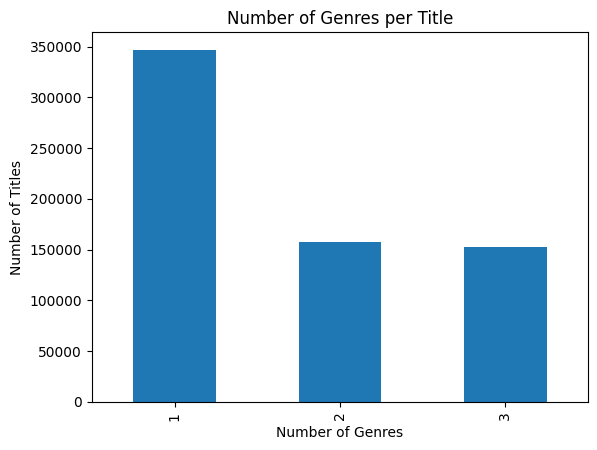

In [44]:
# Most titles have 1 genre, but some have 2 or 3
df['num_genres'].value_counts().plot(
    kind='bar',
    title='Number of Genres per Title',
    xlabel='Number of Genres',
    ylabel='Number of Titles',
)

In [45]:
# Investigate some sample titles - what cleaning is required?
df['title'].sample(20)

232336                                           Derelicts
509303                                     The Russian Dog
598405                                       Lisa at Large
45570                                  The Irony of Fate 2
605352                                          Find Eddie
215280                              Who Would Kill Jessie?
13127                                              Lock-Up
8523                                        Werewolf Woman
84537                  Advent Commando 8: The Dragon Combo
616464                               They Who Are Not Seen
613450                                    Dying to Survive
48410                                     The Investigator
162723                                   If Tomorrow Comes
42336                                    Buenos Aires 1977
204720                               The Song of the Siren
578208                 Gerald R. Ford: A Test of Character
366908                                           Splinte

In [46]:
# Preprocess / the title text

# Remove numberings (i.e. 1st, 2nd, 3rd, etc.) first so the letters aren't
# stranded after removing the numbers (i.e. 1st -> st, 2nd -> nd)
numbering_re = re.compile(r"(\d+(?:st|nd|rd|th))")

# Keep only alpha characters
alpha_re = re.compile(r"[^a-z]+")

# Remove multiple spaces
multi_space_re = re.compile(r"\s+")

# stop_words = set(stopwords.words('english'))
# Use an abbreviated stopword list to preserve as much contextual information as possible
stop_words = ['for', 'the', 'a', 'an', 'in', 'of', 'as', 'at', 'by', 'for', 'on',
    'and', 'to']

# Don't forget to download wordnet if you haven't already!
# nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Converting to lowercase, keeping only alpha characters, and lemmatizing

    Only removing a select number of stopwords since many stopwords may
    contain useful contextual information for classification
    """
    # Convert unicode to ascii version (to preserve words like Pokémon)
    text = unidecode(text)

    # Lowercase, remove numberings (i.e. 1st, 2nd)
    text = text.lower()
    text = numbering_re.sub(" ", text)

    # Remove apostrophes directly as they cause issues with the tokenizer
    text = text.replace("'", "")

    # Keep only alpha characters
    text = alpha_re.sub(" ", text)

    # Turn multiple spaces into a single space
    text = multi_space_re.sub(" ", text)

    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Try without removing stop words first since they may be important for classification
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [47]:
df['title_cleaned'] = df['title'].progress_apply(clean_text)

100%|██████████| 656962/656962 [00:29<00:00, 21975.29it/s]


In [48]:
df.sample(20)[['title', 'title_cleaned', 'genres']]

,title,title_cleaned,genres
608106,State of Exception,"[state, exception]",Documentary
87893,Flower in Snow,"[flower, snow]",Drama
63764,In the Shadows of Casablanca,"[shadow, casablanca]",Documentary
156726,The Fearless Vampire Killers,"[fearless, vampire, killer]","Comedy,Horror"
395857,One Day in Cochin,"[one, day, cochin]","Biography,Comedy,Drama"
239706,A Taste of Death,"[taste, death]",Western
192207,The Unsinkable Shecky Moskowitz,"[unsinkable, shecky, moskowitz]",Comedy
593001,The Alteration of Hudson James,"[alteration, hudson, james]",Drama
283928,Haunted Boat,"[haunted, boat]","Drama,Horror,Mystery"
246620,The Thin Blue Lie,"[thin, blue, lie]",Drama


In [49]:
def dummy_function(text):
    """
    Used to run TfIdf with preapplied tokenization and preprocessing
    """
    return text

In [50]:
# Vectorize the text
vectorizer = TfidfVectorizer(
    tokenizer=dummy_function,
    preprocessor=dummy_function,
    analyzer='word',
    token_pattern=None,
    min_df=3,
)

X = vectorizer.fit_transform(df['title_cleaned'])

In [51]:
# Check our cleaning and tokenization by inspecting most frequent tfidf scores
# Many of the top terms would have been removed had we used a more traditional
# stopword list
tfidf_df = pd.DataFrame(
    {
        'tfidf_score' : np.array(X.sum(axis=0)).T[:,0],
    },
    index=vectorizer.get_feature_names_out().T,
)

tfidf_df.sort_values(by='tfidf_score', ascending=False).head(25)

,tfidf_score
love,5769.790322
my,3797.018098
man,3731.863386
life,3592.484757
night,3332.025216
girl,3325.619874
story,3264.285162
day,3099.897757
woman,2867.456049
i,2849.705651


In [52]:
def query_titles(data=df, query_token=None, column='title_cleaned'):
    """
    Check if a token is in the cleaned title. Used to check token context
    """
    return data[data[column].apply(lambda x: str(query_token).lower() in x)]

## Example function usage
# query_token = 'hook'
# query_titles(query_token=query_token).sample(20)[['title', 'title_cleaned', 'genres']]

In [53]:
def evaluate_model(model_name, y_true, y_pred):
    pass

In [54]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

X_train = vectorizer.transform(train['title_cleaned'])
X_test = vectorizer.transform(test['title_cleaned'])

# Scale the data (only by variance since the input data is a sparse matrix)
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = train[genres]
y_test = test[genres]

In [ ]:
classifiers = [
    {
        'name' : 'Naive Bayes',
        'clf' : OneVsRestClassifier(MultinomialNB(), verbose=1, n_jobs=-1)
    },
    {
        'name' : 'Logistic Regression',
        'clf' : OneVsRestClassifier(LogisticRegression(max_iter=1000,
                                                       verbose=1,),
                                                       verbose=1,
                                                       n_jobs=-1)
    },
    {
        'name' : 'Linear SVC',
        'clf' : OneVsRestClassifier(LinearSVC(max_iter=1000,
                                              verbose=1,),
                                              verbose=1,
                                              n_jobs=-1)
    },
    {
        'name' : 'K-Nearest Neighbors',
        'clf' : KNeighborsClassifier(n_jobs=-1)
    },
    {
        'name' : 'Random Forest',
        'clf' : RandomForestClassifier(verbose=1, n_jobs=-1)
    },
    {
        'name' : 'Gradient Boosted Trees',
        'clf' : OneVsRestClassifier(GradientBoostingClassifier(verbose=1),
                                    verbose=1,
                                    n_jobs=-1)
    },
]

In [ ]:
macro_cols = ['micro avg', 'macro avg', 'weighted avg', 'samples avg']
def eval_model(params):
    clf = params['clf']
    print(f"Training model: {params['name']}")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    macro_results = pd.DataFrame(
        classification_report(
            y_test,
            y_pred,
            target_names=genres,
            output_dict=True
        )
    )[macro_cols].reset_index(names='metric')

    # Add f2-score to macro results
    f2_macro = pd.DataFrame(
        {
            "metric" : ["f2-score"],
            "macro avg" : [fbeta_score(y_test, y_pred, beta=2, average='macro', zero_division=0)],
            "micro avg" : [fbeta_score(y_test, y_pred, beta=2, average='micro', zero_division=0)],
            "weighted avg" : [fbeta_score(y_test, y_pred, beta=2, average='weighted', zero_division=0)],
            "samples avg" : [fbeta_score(y_test, y_pred, beta=2, average='samples', zero_division=0)],
        }
    )
    macro_results = pd.concat([macro_results, f2_macro])
    macro_results['model'] = params['name']
    
    per_class_results = pd.DataFrame(
        classification_report(
            y_test,
            y_pred,
            target_names=genres,
            output_dict=True,
            zero_division=0
        )
    ).drop(columns=macro_cols).T
    
    # Add f2-score to per class results
    f2_scores = fbeta_score(
        y_test,
        y_pred,
        beta=2,
        average=None,
        zero_division=0
    )
    
    per_class_results['f2_score'] = f2_scores

    # save model and results to params dict
    params['clf'] = clf
    params['macro_results'] = macro_results
    params['per_class_results'] = per_class_results
    return macro_results

In [ ]:
results_df = []
for classifier in classifiers:
    try:
        eval_model(classifier)
        clf_macro_results = classifier['macro_results']
        results_df.append(clf_macro_results)
    except Exception as e:
        print(f"Error training model: {classifier['name']}")
        print(e)
        continue

if len(results_df) > 1:
    results_df = pd.concat(results_df)
else:
    results_df = results_df[0]

results_df

Training model: Naive Bayes


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    2.2s finished
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model: Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   40.3s finished
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to contr

Training model: Linear SVC


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eddie/Documents/development/personal

Training model: K-Nearest Neighbors


/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model: Random Forest


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 54.5min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   23.6s finished
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model: Gradient Boosted Trees


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Error training model: Gradient Boosted Trees
WRITEBACKIFCOPY base is read-only


,metric,micro avg,macro avg,weighted avg,samples avg,model
0,precision,0.189205,0.135315,0.301824,0.215552,Naive Bayes
1,recall,0.666408,0.622064,0.666408,0.667378,Naive Bayes
2,f1-score,0.294731,0.202366,0.388976,0.303497,Naive Bayes
3,support,222940.000000,222940.000000,222940.000000,222940.000000,Naive Bayes
0,f2-score,0.442964,0.309664,0.494922,0.429277,Naive Bayes
0,precision,0.591504,0.496356,0.577642,0.387561,Logistic Regression
1,recall,0.283632,0.170990,0.283632,0.308750,Logistic Regression
2,f1-score,0.383414,0.245595,0.359959,0.325987,Logistic Regression
3,support,222940.000000,222940.000000,222940.000000,222940.000000,Logistic Regression
0,f2-score,0.316589,0.193958,0.308050,0.312339,Logistic Regression


In [ ]:
# Random forest is pretty clearly the winner here
results_df.query("metric == 'f2-score'")

,metric,micro avg,macro avg,weighted avg,samples avg,model
0,f2-score,0.442964,0.309664,0.494922,0.429277,Naive Bayes
0,f2-score,0.316589,0.193958,0.308050,0.312339,Logistic Regression
0,f2-score,0.319874,0.200083,0.319384,0.305550,Linear SVC
0,f2-score,0.340744,0.175185,0.329691,0.332442,K-Nearest Neighbors
0,f2-score,0.494019,0.371546,0.489937,0.458931,Random Forest


In [82]:
t_tfidf = TfidfVectorizer(
                tokenizer=lambda x: x,
                preprocessor=lambda x: x,
                analyzer='word',
                token_pattern=None,
                stop_words=None,
                min_df=2,   
            )

t_tfidf.fit(X_train)

TfidfVectorizer(min_df=2, preprocessor=<function <lambda> at 0x28db9a550>,
                token_pattern=None,
                tokenizer=<function <lambda> at 0x28db9a670>)

In [84]:
in_text = 'The Lord of the Rings: The Return of the King'
in_text_cleaned = clean_text(in_text)
in_text_vec = t_tfidf.transform([in_text_cleaned])
in_text_vec

<1x40883 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [76]:
# Hyperparameter tuning failed using RandomizedSearchCV because of memory
# constraints. Instead starting with slightly increased parameters from the first
# model and working from there
# Test one more model here before training with the entire training set

X = df['title_cleaned']
y = df[genres]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
                tokenizer=lambda x: x,
                preprocessor=lambda x: x,
                analyzer='word',
                token_pattern=None,
                stop_words=None,
                min_df=2,   
            )
    ),
    ('rf', RandomForestClassifier(
            verbose=1,
            n_jobs=-1,
            n_estimators=1,
            min_samples_leaf=1,
            min_samples_split=2,
         )
    )
])

rf_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  5.5min finished


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=2,
                                 preprocessor=<function <lambda> at 0x28da9a550>,
                                 token_pattern=None,
                                 tokenizer=<function <lambda> at 0x30486faf0>)),
                ('rf',
                 RandomForestClassifier(n_estimators=1, n_jobs=-1, verbose=1))])

In [ ]:
y_pred = rf_pipeline.predict(X_test)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s finished


In [ ]:
f2_scores = fbeta_score(y_test, y_pred, beta=2, average='weighted', zero_division=0)

In [92]:
# Save out pipeline object
with open(str(MODEL_PATH), 'wb') as f:
    dill.dump(rf_pipeline, f)

In [125]:
# Full prediction pipeline
text = "The Adventures of Sherlock Holmes"

# Pipeline expects a List of lists
cleaned_text = [clean_text(text)]
pred = rf_pipeline.predict(cleaned_text)
pred = pred.flatten()
pred_genres = [genres[i] for i in range(len(pred)) if pred[i] == 1]
pred_genres

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


['Drama', 'Mystery']

In [132]:
# Save off genres so the order is preserved
pd.Series(genres).to_csv(GENRES_PATH, index=False)